In [3]:
import pandas as pd
import numpy as np
import pythainlp
import pickle
import tensorflow as tf
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

from pythainlp.corpus.common import thai_stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from keras.utils import pad_sequences
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau

In [4]:
# Set the maximum number of words to keep based on word frequency
max_words = 10000
maxlen = 128  # Set the maximum sequence length
# Load the data from the CSV file
df = pd.read_csv('C:/Project-Sentiment-Analysis/Sentiment-Analysis-Model/datasets/datasetSUMTH.csv')
# dfpos = pd.read_csv('C:/Sentiment-Analysis-Model/datasets/datasetEN_filtered_POS.csv')
# dfneg = pd.read_csv('C:/Sentiment-Analysis-Model/datasets/datasetEN_filtered_NEG.csv')
# dfneu = pd.read_csv('C:/Sentiment-Analysis-Model/datasets/datasetEN_filtered_NEU.csv')

# df = pd.concat([df, dfpos, dfneg, dfneu], ignore_index=True)

data = df.drop_duplicates().copy()  # Make a copy of the DataFrame

# Define preprocess for Thai text
def preprocess_text(text):
    if pd.isnull(text):  # Check if text is NaN
        return ''
    # tokenize the text
    text = emoji.demojize(text)
    text = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ"))
    text = re.sub(r'[a-zA-Z]', '', text)  # Remove English characters
    text = " ".join(word for word in text)
    text = "".join(word for word in text.split() if word.lower() not in thai_stopwords())
    tokens = pythainlp.word_tokenize(str(text), engine='newmm')
    # join the tokens back into a single string
    text = " ".join(tokens)
    # remove non-alphabetic characters and extra whitespaces
    text = re.sub('[^A-Za-zก-๙]+', ' ', text).strip()
    return text

# Apply the preprocessing function to the 'text' column using loc
data.loc[:, 'text'] = data['text'].apply(preprocess_text)

# Split the data into text and labels
x = data['text'].values
y = data['sentiment'].values

# Filter out empty texts (NaN)
non_empty_indices = ~pd.isnull(x)
x = x[non_empty_indices]
y = y[non_empty_indices]

# Convert the sentiment labels to one-hot encoded vectors
y = pd.get_dummies(y).values

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Create the Tokenizer object without passing a custom tokenizer function
tokenizer = Tokenizer(num_words=max_words, filters='', lower=False, oov_token='<UNK>')
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# Pad the sequences to a fixed length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

print("maxlen: ", maxlen)


maxlen:  128


<Axes: xlabel='sentiment'>

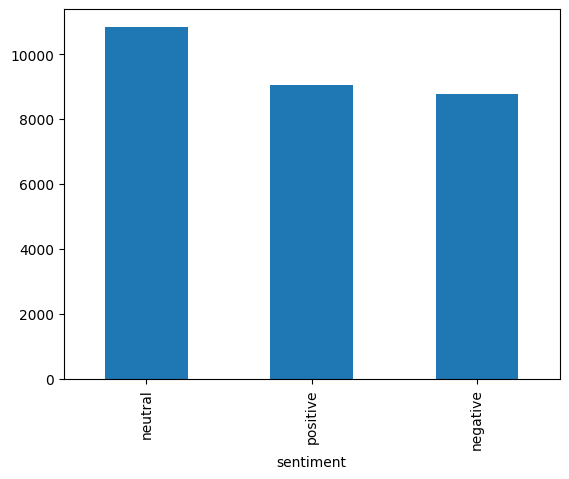

In [5]:
data['sentiment'].value_counts().plot.bar()

In [6]:
# Create the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 124, 128)          82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

In [7]:
# Train the model
filename = 'sentiment_analysis_modelTH.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=0.000001)
callbacks_list = [checkpoint, learning_rate_reduction]

history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks_list)

Epoch 1/10
358/359 [============================>.] - ETA: 0s - loss: 0.7988 - accuracy: 0.6353
Epoch 1: val_loss improved from inf to 0.60904, saving model to sentiment_analysis_modelTH.h5
359/359 [==============================] - 23s 60ms/step - loss: 0.7983 - accuracy: 0.6356 - val_loss: 0.6090 - val_accuracy: 0.7506 - lr: 0.0010
Epoch 2/10
358/359 [============================>.] - ETA: 0s - loss: 0.5176 - accuracy: 0.8020
Epoch 2: val_loss improved from 0.60904 to 0.59462, saving model to sentiment_analysis_modelTH.h5
359/359 [==============================] - 22s 61ms/step - loss: 0.5175 - accuracy: 0.8021 - val_loss: 0.5946 - val_accuracy: 0.7582 - lr: 0.0010
Epoch 3/10
358/359 [============================>.] - ETA: 0s - loss: 0.3538 - accuracy: 0.8708
Epoch 3: val_loss did not improve from 0.59462
359/359 [==============================] - 23s 63ms/step - loss: 0.3539 - accuracy: 0.8707 - val_loss: 0.6400 - val_accuracy: 0.7534 - lr: 0.0010
Epoch 4/10
358/359 [===============

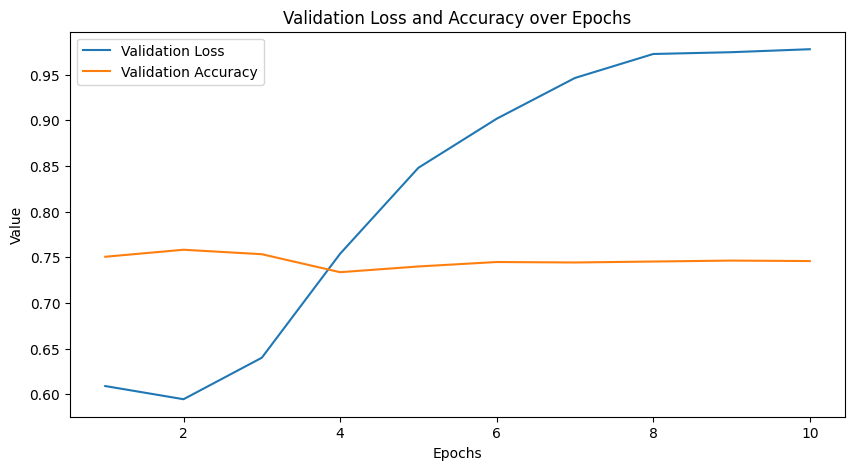

In [8]:
# Get the epoch numbers
epochs = range(1, len(history.history['val_loss']) + 1)

# Plot validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy over Epochs')
plt.legend()
plt.show()

Validation Loss: 0.5946165919303894
Validation Accuracy: 0.7582359910011292
180/180 [==============================] - 2s 8ms/step
Class: pos
Precision: 0.7940261356565028
Recall: 0.7392815758980301
F1-score: 0.7656765676567657

Class: neg
Precision: 0.7269723254853366
Recall: 0.822814399251987
F1-score: 0.7719298245614036

Class: neu
Precision: 0.7688706846108836
Recall: 0.7019230769230769
F1-score: 0.7338732197710137



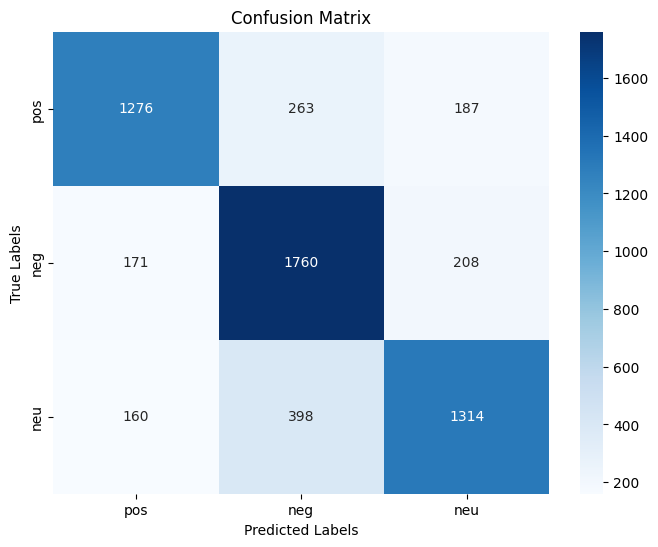

In [9]:
# Load the best model
model = load_model(filename)

# Compute validation loss and accuracy
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Predict classes for test data
y_pred = model.predict(x_test)
predicted_classes = np.argmax(y_pred, axis=1)

# Define class labels
class_labels = ['pos', 'neg', 'neu']

# Compute confusion matrix
confusion_mat = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)

# Calculate precision, recall, and F1-score
# Get the true labels and predicted labels
y_true = np.argmax(y_test, axis=1)
y_pred = predicted_classes

# Calculate precision for each class
precision = precision_score(y_true, y_pred, average=None)

# Calculate recall for each class
recall = recall_score(y_true, y_pred, average=None)

# Calculate F1-score for each class
f1 = f1_score(y_true, y_pred, average=None)

# Print precision, recall, and F1-score for each class
for i in range(len(class_labels)):
    print(f"Class: {class_labels[i]}")
    print("Precision:", precision[i])
    print("Recall:", recall[i])
    print("F1-score:", f1[i])
    print()
    
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Save the trained model and the tokenizer to disk
model.save('sentiment_analysis_modelTH.h5')
with open('tokenizerTH.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [11]:
#load model and tokenizer
with open('tokenizerTH.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

model = load_model('sentiment_analysis_modelTH.h5')

In [14]:
new_text = 'ใช้ดีค่ะไม่ระคายเคืองผิวหน้า หลังใช้รับรู้ได้ถึงความสะอาดของผิวหน้ามากขึ้น หลังใช้ไปสักระยะสิวลดลงค่ะ'
new_text = preprocess_text(new_text)
print('new_text:', new_text)
new_text = tokenizer.texts_to_sequences([new_text])  # Convert text to sequences of integers
new_text = pad_sequences(new_text, maxlen=maxlen)
# Make the prediction
prediction = model.predict(new_text)[0]

# Get the predicted sentiment and confidence level
sentiments = ['Negative', 'Neutral', 'Positive']
sentiment = sentiments[np.argmax(prediction)]
confidence = np.max(prediction)

# Display the result
print(f'{sentiment} ({confidence * 100:.2f}%)')

new_text: ใช้ ดี ค่ะ ไม่ ระคายเคือง ผิวหน้า หลัง ใช้ รับรู้ ได้ ถึง ความสะอาด ของ ผิวหน้า มากขึ้น หลัง ใช้ ไป สัก ระยะ สิว ลดลง ค่ะ
1/1 [==============================] - 0s 24ms/step
Negative (62.53%)
